  # Credit Default Risk - Credit Scoring and Analytics

 Nicodemus Naisau - Portfolio Project

![Alt text](https://img.freepik.com/free-vector/flat-design-credit-assessment-concept-with-laptop_23-2149163902.jpg?size=626&ext=jpg&ga=GA1.1.1826414947.1699228800&semt=ais"ilustration")

---
**Outline**

1. Data Preparation
2. Data Exploration
3. Initial Characteristic Analysis
4. Design Scorecards
5. Scaling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, confusion_matrix
from ipywidgets import interact, FloatSlider
from scikitplot.metrics import plot_roc_curve
from ipywidgets import Play, jslink, HBox, interactive_output
from IPython.display import display
import warnings
import pickle
warnings.filterwarnings('ignore')

# **1. Data Preparation**
---

## **1.1 Load Data**
---

The sample we will use in this example is a fictive dataset from [here](https://www.kaggle.com/datasets/somyaagarwal69/loan-data-2015).

The raw data includes information on over 450,000 consumer loans issued in the year 2015 with almost 75 features, including the current loan status and various attributes related to both borrowers and their payment behavior.

Note that we are will defining the default or bad status from our dataset here (loan_status). we have convert into the binary response variable:

- `loan_status`
  - `Charged Off`
  - `Current`
  - `Default`
  - `Fully Paid`
  - `In Grace Period`
  - `Issued`
  - `Late (16-30 days)`
  - `Late (31-120 days)`

The potential predictors for predicting the response variable are:

1. `annual_inc` : annual income of the debtor.
2. `home_ownership`
  - `RENT`
  - `MORTGAGE`
  - `OWN`
  - `OTHER`
3. `emp_length` : employment length of debtor (in years).
4. `purpose` : purpose of the loan.
  - `EDUCATION`
  - `MEDICAL`
  - `VENTURE`
  - `PERSONAL`
  - `DEBTCONSOLIDATION`
5. `grade`
6.  `loan_amnt`	: amount of the loan.
7. `int_rate` : interest rate of the loan.
8. `dti`: Debt-to-Income Ratio (DTI)

In [3]:
# read dataset function
def read_data(path):
    """
    Reads a CSV file at the given path, removes any duplicate rows,
    and returns its contents as a pandas DataFrame.

    Parameters
    ----------
    path : str
        input path

    Returns
    -------
    df : pandas Dataframe
        Sample dataframe
    """
    # 1. Read data
    data = pd.read_csv(path,
                       index_col = 0,
                       low_memory = False) # Disable automatic type inference for memory efficiency

    # 2. Drop duplicates
    data = data.drop_duplicates()

    # 3. print data shape
    print('Data shape :', data.shape)

    return data

In [4]:
# Read data
data = read_data(path = 'loan_data_2015.csv')

Data shape : (421094, 73)


In [5]:
# check the data
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,
60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,Accounting Clerk,...,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,Accounts Payable Lead,...,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,Nurse,...,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,Service Manager,...,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN


In [6]:
# check data duplicate
data.duplicated().sum()

0

Our sample contains 73 variables from 421,094 credit records.
- 1 response variable, `loan_status`,
- and 73 potential predictors/characteristics.

Before modeling, make sure you split the data first for model validation.

In the classification case, check the proportion of response variable first to decide the splitting strategy.

https://www.kaggle.com/code/deepakvk18/credit-default-risk/notebook

In [7]:
data['loan_status'].unique()

array(['Charged Off', 'Current', 'Default', 'Fully Paid',
       'In Grace Period', 'Issued', 'Late (16-30 days)',
       'Late (31-120 days)'], dtype=object)

lets convert loan_status as a loan_status value 1 and 0

In [8]:
unique_value = (data['loan_status'] != 'Current') & (data['loan_status'] != 'Issued') & (data['loan_status'] != 'Late (16-30 days)') & (data['loan_status'] != 'In Grace Period')
data = data[mask]
data['loan_status'] = np.where((data['loan_status'] == 'Charged Off') | (data['loan_status'] == 'Late (31-120 days)') | (data['loan_status'] == 'Default'), 1, 0)

<div style="font-family: Arial; list-style-type: none; padding: 10px; border-radius: 10px; ">
    I will be including the following loan statuses from our analysis, as non-risky:
<ul><li>🐬
<b> Fully Paid </b> : refers to the people who have already paid off the loan and are non-risky.</li></ul>
    I will consider the following loan statuses as risky:
<ul><li>🐬
<b> Charged off</b> : means the borrower has been deemed incapable of paying the loan and it will be marked under NPA(Non Performing Asset).</li>
    <li>🐬<b> Default</b> : means the borrower has not paid his/her loan even after 120 days.</li>
    <li>🐬
<b>Late (31-120 days) </b> : means that the borrower has not paid the amount on time and there is a delay in payment of more than 31 days, this label comes under risky loan.</li></ul>
I will also be excluding the following loan statuses from our analysis, as they can go both ways:
<ul>
    <li>
<b> 
    🐬 Current</b> : refers to the current loan cycle, but there is a probability that they might default in future.</li><li>
<b> 🐬 In Grace Period </b> : means the borrower has delayed his payment by 1-15 days, this comes under non-risky loan, but if the borrower does not pay, it becomes risky. Since we cannot say whether the borrower will default or not as of yet, this category  won't be used for the analysis.</li><li>
<b> 🐬 Late(16-30 days)</b> : means that the borrower has delayed his payments by 16-30 days, this can also go both ways, so we are not going to use this label in our analysis.</li>
    <li>🐬
<b> Issued </b> : refers to the loan has been issued just and the payment cycle has not begun, but there is a probability that the borrower may default in future.</li></ul>  
    </div>

In [9]:
# Define response variable
response_variable = 'loan_status'

# Check the proportion of response variable
data[response_variable].value_counts(normalize = True)

0    0.745387
1    0.254613
Name: loan_status, dtype: float64

The proportion of the response variable, `loan status`, is not quite balanced (in a ratio of 75:25).

To get the same ratio in training and testing set, define a stratified splitting based on the response variable, `loan_status`.

Lets do selection for field have meaning purpose for analysis and modeling, after the list, we have 

- `loan_amnt`,
- `int_rate`,
- `grade`
- `annual_inc`
- `emp_length`
- `purpose`
- `verification_status`
- `home_ownership`
- `loan_status`


In [10]:
loan =[
    'loan_amnt',
    'int_rate',
    'grade',
    'annual_inc',
    'emp_length',
    'purpose',
    'loan_status',
    'verification_status',
    'home_ownership',
    'dti'
]

data = data[loan]

### Check for Types Fields
--- 

The anomaly exists in the 'emp_length' data, where the type is listed as an object, yet the values within represent the duration in integer years. Therefore, it is necessary to convert these into numerical values.

In [11]:
data['emp_length'].unique()

array(['1 year', '7 years', '6 years', '10+ years', nan, '8 years',
       '9 years', '3 years', '4 years', '< 1 year', '2 years', '5 years'],
      dtype=object)

In [12]:
emp_length_mapping = {
    '10+ years': 10,
    '9 years': 9,
    '8 years': 8,
    '7 years': 7,
    '6 years': 6,
    '5 years': 5,
    '4 years': 4,
    '3 years': 3,
    '2 years': 2,
    '1 year': 1,
    '< 1 year': 0.5,
    ' ': 0
}
data['emp_length'] = data['emp_length'].replace(emp_length_mapping)

data['emp_length'].astype('float64')

id
60516983     1.0
60187139     7.0
60356453     6.0
59955769    10.0
58703693     NaN
            ... 
37257620    10.0
35998858     3.0
37317288     2.0
36200493     NaN
37011266     3.0
Name: emp_length, Length: 30835, dtype: float64

In [13]:
data['emp_length'].unique()

array([ 1. ,  7. ,  6. , 10. ,  nan,  8. ,  9. ,  3. ,  4. ,  0.5,  2. ,
        5. ])

In [14]:
# Check for data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30835 entries, 60516983 to 37011266
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            30835 non-null  int64  
 1   int_rate             30835 non-null  float64
 2   grade                30835 non-null  object 
 3   annual_inc           30835 non-null  float64
 4   emp_length           29270 non-null  float64
 5   purpose              30835 non-null  object 
 6   loan_status          30835 non-null  int32  
 7   verification_status  30835 non-null  object 
 8   home_ownership       30835 non-null  object 
 9   dti                  30835 non-null  float64
dtypes: float64(4), int32(1), int64(1), object(4)
memory usage: 2.5+ MB


## **1.2 Sample Splitting**
---

First, define the predictors (X) and the response (y).

In [15]:
# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (30835,)
X shape : (30835, 9)


In [16]:
# Split response and predictors
y = data[response_variable]
X = data.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (30835,)
X shape : (30835, 9)


Next, split the training and testing set from each predictors (X) and response (y).
- Set `stratify = y` for splitting the sample with stratify, based on the proportion of response y.
- Set `test_size = 0.3` for holding 30% of the sample as a testing set.
- Set `random_state = 42` for reproducibility.

In [17]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (21584, 9)
y train shape : (21584,)
X test shape  : (9251, 9)
y test shape  : (9251,)


Check the proportion of response y in each training and testing set.

In [18]:
y_train.value_counts(normalize = True)

0    0.745367
1    0.254633
Name: loan_status, dtype: float64

In [19]:
y_test.value_counts(normalize = True)

0    0.745433
1    0.254567
Name: loan_status, dtype: float64

# **2. Data Exploration**
---  

## **2.1 Exploratory Data Analysis (EDA)**

ake a model that predicts well on unseen data, we must prevent leakage of test set information.
- Thus, we only explore on **training set**.

In [20]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train),
                       axis = 1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (21584, 10)


,loan_amnt,int_rate,grade,annual_inc,emp_length,purpose,verification_status,home_ownership,dti,loan_status
id,,,,,,,,,,
40634215,11875,18.84,E,73000.0,10.0,credit_card,Verified,RENT,31.35,1
40017494,20000,12.99,C,75000.0,10.0,debt_consolidation,Source Verified,MORTGAGE,16.66,0
39750768,14400,17.14,D,70900.0,5.0,debt_consolidation,Not Verified,RENT,37.86,1
46566810,15000,6.92,A,84633.0,7.0,debt_consolidation,Not Verified,OWN,17.01,0
46834123,35000,16.55,D,248000.0,10.0,debt_consolidation,Source Verified,MORTGAGE,18.39,1


What do we do in EDA?
- Check data integrity.
- Check for any insight in the data: distribution, proportion, outliers, missing values, etc.
- Make a plan for data pre-processing.

### Check for Missing Values
--- 

In [21]:
# Check for missing values
data_train.isna().sum()

loan_amnt                 0
int_rate                  0
grade                     0
annual_inc                0
emp_length             1104
purpose                   0
verification_status       0
home_ownership            0
dti                       0
loan_status               0
dtype: int64

In [22]:
# Check for data type
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21584 entries, 40634215 to 38311887
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            21584 non-null  int64  
 1   int_rate             21584 non-null  float64
 2   grade                21584 non-null  object 
 3   annual_inc           21584 non-null  float64
 4   emp_length           20480 non-null  float64
 5   purpose              21584 non-null  object 
 6   verification_status  21584 non-null  object 
 7   home_ownership       21584 non-null  object 
 8   dti                  21584 non-null  float64
 9   loan_status          21584 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(4)
memory usage: 1.7+ MB


**Summary**
- There are missing values in `emp_length`
- We need to find how to handle the missing values by exploring the variables.

## **2.2 Check Correlation**
--- 

We'll calculate the Pearson correlation between numerical predictors to see whether we have multicollinearity in training set.

First, define the list of numerical and categorical predictors.

### Define Numerical and Categorical Predictors
---

In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21584 entries, 40634215 to 38311887
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            21584 non-null  int64  
 1   int_rate             21584 non-null  float64
 2   grade                21584 non-null  object 
 3   annual_inc           21584 non-null  float64
 4   emp_length           20480 non-null  float64
 5   purpose              21584 non-null  object 
 6   verification_status  21584 non-null  object 
 7   home_ownership       21584 non-null  object 
 8   dti                  21584 non-null  float64
 9   loan_status          21584 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(4)
memory usage: 1.7+ MB


In [24]:
# Define data with numerical predictors
num_columns = ['loan_amnt',
               'int_rate',
               'annual_inc',
               'emp_length',
              'dti']

In [121]:
num_columns

['loan_amnt', 'int_rate', 'annual_inc', 'emp_length', 'dti']

In [25]:
# Define data with categorical predictors
cat_columns =  ['grade',
                'purpose',
                'verification_status',
                'home_ownership']   

### Check Multicollinearity
---
Next, calculate the Pearson correlation coefficient between numerical predictors.

In [26]:
# Calculate Pearson correlation coefficient from numerical predictors
data_train_corr = data_train[num_columns].corr(method = 'pearson')

data_train_corr

,loan_amnt,int_rate,annual_inc,emp_length,dti
loan_amnt,1.000000,0.227218,0.335081,0.070806,0.002501
int_rate,0.227218,1.000000,-0.082060,-0.013094,0.196736
annual_inc,0.335081,-0.082060,1.000000,0.056691,-0.194816
emp_length,0.070806,-0.013094,0.056691,1.000000,0.016612
dti,0.002501,0.196736,-0.194816,0.016612,1.000000


<AxesSubplot: >

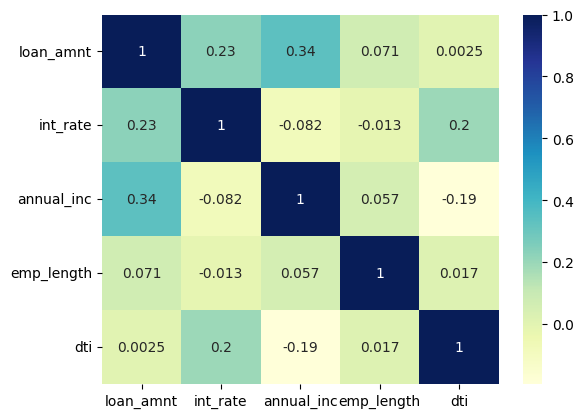

In [27]:
# Plot the heatmap correlation
sns.heatmap(data = data_train_corr,
            cmap = "YlGnBu",
            annot = True)

It appears that each attribute has a 
low correlation with each other

# **3. Initial Characteristic Analysis**
---

We know from EDA that we have missing values in numerical predictors `emp_length` 

Here, we will group the missing values in each predictor to retain the sample's information as it is.

### **3.1 Characteristic Binning**
---

Create a function for binning the numerical predictors.

In [28]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning numerical predictor.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    num_of_bins : integer
      The number of bins.


    Return
    ------
    data : array like
      The name of transformed dataset.

    """
    # Create a new column containing the binned predictor
    data[predictor_label + "_bin"] = pd.qcut(data[predictor_label],
                                             q = num_of_bins, duplicates='drop')

    return data

In [29]:
for column in num_columns:
  data_train_binned = create_binning(data = data_train,
                                     predictor_label = column,
                                     num_of_bins = 4)

In [30]:
data_train_binned.T

id,40634215,40017494,39750768,46566810,46834123,46644043,56040180,40097697,39380008,42474693,...,39652306,38282010,43335374,43014412,49925638,51035774,40930976,40277505,48050865,38311887
loan_amnt,11875,20000,14400,15000,35000,16550,10400,8000,4800,14500,...,16475,24000,35000,13000,5000,24000,5200,12000,35000,10775
int_rate,18.84,12.99,17.14,6.92,16.55,22.99,23.99,15.99,13.66,13.99,...,14.31,14.31,21.67,13.99,12.69,11.53,12.69,21.99,15.61,13.66
grade,E,C,D,A,D,F,F,D,C,C,...,C,C,E,C,C,B,C,E,D,C
annual_inc,73000.0,75000.0,70900.0,84633.0,248000.0,39457.6,47000.0,196000.0,40000.0,48000.0,...,54903.0,126314.0,75004.0,64000.0,80000.0,120000.0,42000.0,26000.0,161000.0,54000.0
emp_length,10.0,10.0,5.0,7.0,10.0,2.0,5.0,7.0,3.0,10.0,...,5.0,6.0,5.0,0.5,7.0,2.0,0.5,1.0,9.0,0.5
purpose,credit_card,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,...,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,debt_consolidation,other,debt_consolidation
verification_status,Verified,Source Verified,Not Verified,Not Verified,Source Verified,Source Verified,Source Verified,Source Verified,Verified,Source Verified,...,Not Verified,Verified,Verified,Source Verified,Not Verified,Source Verified,Source Verified,Source Verified,Verified,Not Verified
home_ownership,RENT,MORTGAGE,RENT,OWN,MORTGAGE,RENT,MORTGAGE,RENT,RENT,OWN,...,MORTGAGE,MORTGAGE,RENT,RENT,RENT,MORTGAGE,RENT,RENT,MORTGAGE,MORTGAGE
dti,31.35,16.66,37.86,17.01,18.39,13.41,22.55,25.68,15.08,28.1,...,16.96,23.65,12.61,19.73,6.96,13.58,23.89,30.47,6.39,14.72
loan_status,1,0,1,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0


#### Missing Values Binning

Remember we have missing values in some numerical predictors.

Here we will group the missing values.

In [31]:
# Check for missing values
data_train_binned.isna().sum()

loan_amnt                 0
int_rate                  0
grade                     0
annual_inc                0
emp_length             1104
purpose                   0
verification_status       0
home_ownership            0
dti                       0
loan_status               0
loan_amnt_bin             0
int_rate_bin              0
annual_inc_bin            0
emp_length_bin         1104
dti_bin                   0
dtype: int64

In [32]:
# # Define columns with missing values
# missing_columns = ['person_emp_length_bin',
#                    'loan_int_rate_bin',
#                    'cb_person_cred_hist_length_bin']

# Define columns with missing values
missing_columns = ['emp_length_bin']

In [33]:
# Perform grouping for all columns
for column in missing_columns:

  # Add category 'Missing' to replace the missing values
  data_train_binned[column] = data_train_binned[column].cat.add_categories('Missing')

  # Replace missing values with category 'Missing'
  data_train_binned[column].fillna(value = 'Missing',
                                   inplace = True)

In [34]:
# Sanity check
data_train_binned.isna().sum()

loan_amnt                 0
int_rate                  0
grade                     0
annual_inc                0
emp_length             1104
purpose                   0
verification_status       0
home_ownership            0
dti                       0
loan_status               0
loan_amnt_bin             0
int_rate_bin              0
annual_inc_bin            0
emp_length_bin            0
dti_bin                   0
dtype: int64

### **3.2 WoE and IV**
---  
To assess the strength of each characteristic individually as a predictor of the credit performance.

First, create a contingency table/crosstab for all predictors: numerical and categorical predictors.

In [35]:
# Define the initial empty list
crosstab_num = []

for column in num_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column + "_bin"],
                         data_train_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_num.append(crosstab)

In [36]:
# Define the initial empty list
crosstab_cat = []

for column in cat_columns:

  # Create a contingency table
  crosstab = pd.crosstab(data_train_binned[column],
                         data_train_binned[response_variable],
                         margins = True)

  # Append to the list
  crosstab_cat.append(crosstab)

In [37]:
# Put all two in a crosstab_list
crosstab_list = crosstab_num + crosstab_cat

crosstab_list

[loan_status             0     1    All
 loan_amnt_bin                         
 (999.999, 8000.0]    4691  1249   5940
 (8000.0, 12600.0]    3601  1286   4887
 (12600.0, 20000.0]   4197  1580   5777
 (20000.0, 35000.0]   3599  1381   4980
 All                 16088  5496  21584,
 loan_status         0     1    All
 int_rate_bin                      
 (5.319, 10.99]   4990   675   5665
 (10.99, 13.66]   4140  1100   5240
 (13.66, 17.14]   3729  1571   5300
 (17.14, 28.99]   3229  2150   5379
 All             16088  5496  21584,
 loan_status               0     1    All
 annual_inc_bin                          
 (6634.999, 45000.0]    3720  1710   5430
 (45000.0, 65000.0]     4390  1488   5878
 (65000.0, 90000.0]     3855  1194   5049
 (90000.0, 6000000.0]   4123  1104   5227
 All                   16088  5496  21584,
 loan_status         0     1    All
 emp_length_bin                    
 (0.499, 2.0]     3716  1470   5186
 (2.0, 6.0]       3759  1371   5130
 (6.0, 10.0]      7881  228

Next, calculate the WOE and IV for each crosstab.

- Weight of Evidence (WoE) — measures the strength of each attribute.

$$
\begin{align*}
W_i &= \ln ( \% \text{Good} / \% \text{Bad} ) \\
W_i &= \ln \left ( \left ( \frac{N_i}{\sum N} \right ) / \left ( \frac{P_i}{\sum P} \right )\right ) \\
\end{align*}
$$

- Information Value (IV) — measures the total strength of the characteristic.

$$
\begin{align*}
IV &= \sum_{i=1}^{n} ( \% \text{Good} - \% \text{Bad} ) \times W_i \\
IV &= \sum_{i=1}^{n}\left [ \left ( \frac{N_i}{\sum N} - \frac{P_i}{\sum P} \right ) \times W_i \right ] \\
\end{align*}
$$

In [38]:
# Define the initial list for WOE
WOE_list = []

# Define the initial list for IV
IV_list = []

# Create the initial table for IV
IV_table = pd.DataFrame({'Characteristic': [],
                         'Information Value' : []})

# Perform the algorithm for all crosstab
for crosstab in crosstab_list:

  # Calculate % Good
  crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

  # Calculate % Bad
  crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

  # Calculate the WOE
  crosstab['WOE'] = np.log(crosstab['p_good']/crosstab['p_bad'])

  # Calculate the contribution value for IV
  crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

  # Calculate the IV
  IV = crosstab['contribution'][:-1].sum()

  add_IV = {'Characteristic': crosstab.index.name,
            'Information Value': IV}

  WOE_list.append(crosstab)
  IV_list.append(add_IV)

In [39]:
WOE_list

[loan_status             0     1    All    p_good     p_bad       WOE  \
 loan_amnt_bin                                                          
 (999.999, 8000.0]    4691  1249   5940  0.291584  0.227256  0.249249   
 (8000.0, 12600.0]    3601  1286   4887  0.223831  0.233988 -0.044378   
 (12600.0, 20000.0]   4197  1580   5777  0.260878  0.287482 -0.097108   
 (20000.0, 35000.0]   3599  1381   4980  0.223707  0.251274 -0.116205   
 All                 16088  5496  21584  1.000000  1.000000  0.000000   
 
 loan_status         contribution  
 loan_amnt_bin                     
 (999.999, 8000.0]       0.016034  
 (8000.0, 12600.0]       0.000451  
 (12600.0, 20000.0]      0.002583  
 (20000.0, 35000.0]      0.003203  
 All                     0.000000  ,
 loan_status         0     1    All    p_good     p_bad       WOE  contribution
 int_rate_bin                                                                  
 (5.319, 10.99]   4990   675   5665  0.310169  0.122817  0.926425      0.1

In [40]:
# Create initial table to summarize the WOE values
WOE_table = pd.DataFrame({'Characteristic': [],
                          'Attribute': [],
                          'WOE': []})

for i in range(len(crosstab_list)):

  # Define crosstab and reset index
  crosstab = crosstab_list[i].reset_index()

  # Save the characteristic name
  char_name = crosstab.columns[0]

  # Only use two columns (Attribute name and its WOE value)
  # Drop the last row (average/total WOE)
  crosstab = crosstab.iloc[:-1, [0,-2]]
  crosstab.columns = ['Attribute', 'WOE']

  # Add the characteristic name in a column
  crosstab['Characteristic'] = char_name

  WOE_table = pd.concat((WOE_table, crosstab),
                        axis = 0)

  # Reorder the column
  WOE_table.columns = ['Characteristic',
                       'Attribute',
                       'WOE']

WOE_table

,Characteristic,Attribute,WOE
0,loan_amnt_bin,"(999.999, 8000.0]",0.249249
1,loan_amnt_bin,"(8000.0, 12600.0]",-0.044378
2,loan_amnt_bin,"(12600.0, 20000.0]",-0.097108
3,loan_amnt_bin,"(20000.0, 35000.0]",-0.116205
0,int_rate_bin,"(5.319, 10.99]",0.926425
1,int_rate_bin,"(10.99, 13.66]",0.251333
2,int_rate_bin,"(13.66, 17.14]",-0.209625
3,int_rate_bin,"(17.14, 28.99]",-0.667348
0,annual_inc_bin,"(6634.999, 45000.0]",-0.296823
1,annual_inc_bin,"(45000.0, 65000.0]",0.007843


In [41]:
# Put all IV in the table
IV_table = pd.DataFrame(IV_list)
IV_table

,Characteristic,Information Value
0,loan_amnt_bin,0.022271
1,int_rate_bin,0.326393
2,annual_inc_bin,0.039423
3,emp_length_bin,0.027479
4,dti_bin,0.115011
5,grade,0.368470
6,purpose,0.016371
7,verification_status,0.039140
8,home_ownership,0.060851


The rule of thumb regarding IV:
- Less than 0.02 : generally unpredictive
- 0.02 to 0.1 : weak
- 0.1 to 0.3 : medium
- 0.3+ : strong

In [42]:
# Define the predictive power of each characteristic
strength = []

# Assign the rule of thumb regarding IV
for iv in IV_table['Information Value']:
  if iv < 0.02:
    strength.append('Unpredictive')
  elif iv >= 0.02 and iv < 0.1:
    strength.append('Weak')
  elif iv >= 0.1 and iv < 0.3:
    strength.append('Medium')
  elif iv >= 0.3 and iv < 0.5:
    strength.append('Strong')
  else:
    strength.append('Very strong')

# Assign the strength to each characteristic
IV_table = IV_table.assign(Strength = strength)

# Sort the table by the IV values
IV_table.sort_values(by='Information Value')

,Characteristic,Information Value,Strength
6,purpose,0.016371,Unpredictive
0,loan_amnt_bin,0.022271,Weak
3,emp_length_bin,0.027479,Weak
7,verification_status,0.039140,Weak
2,annual_inc_bin,0.039423,Weak
8,home_ownership,0.060851,Weak
4,dti_bin,0.115011,Medium
1,int_rate_bin,0.326393,Strong
5,grade,0.368470,Strong


From the IV table:
- We have 1 unpredictive and 5 weak characteristics,  2 strong.

Before performing model selection in modeling, we will check the independency between each characteristic with the response variable `loan_status`.

Before that, we'll check the logical trend and operational/business considerations from the WOE in each characteristic.

### **3.3 Check Logical Trend and Business Consideration**
---

In grouped scorecards, the attribute strengths must also be in a logical order, and make operational sense.

In [43]:
char_list = IV_table['Characteristic'].tolist()
char_list

['loan_amnt_bin',
 'int_rate_bin',
 'annual_inc_bin',
 'emp_length_bin',
 'dti_bin',
 'grade',
 'purpose',
 'verification_status',
 'home_ownership']

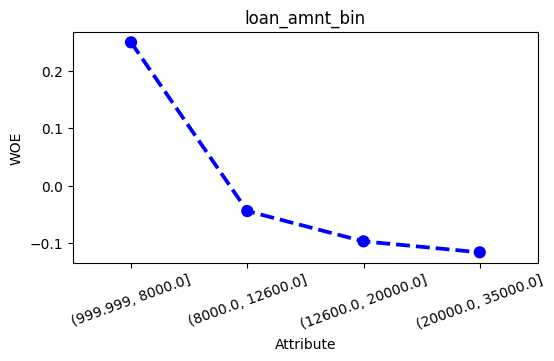

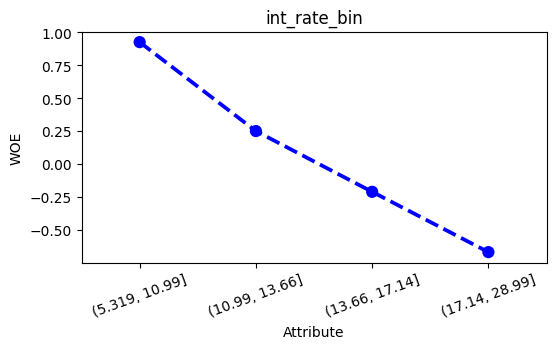

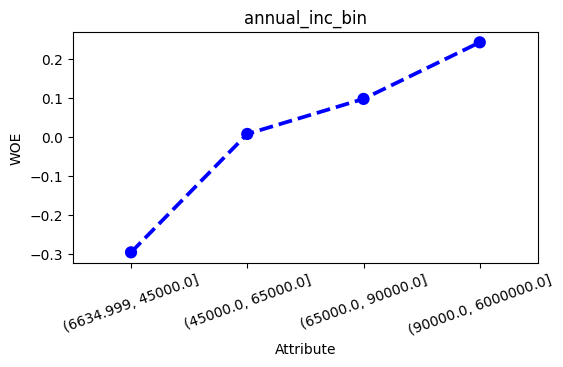

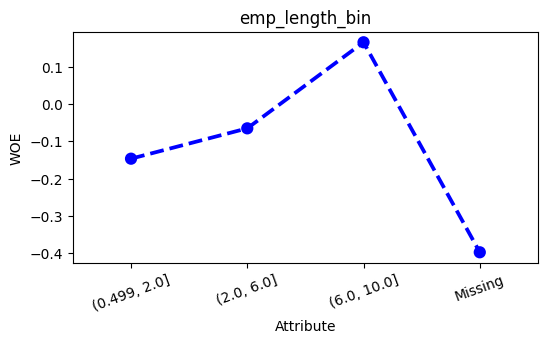

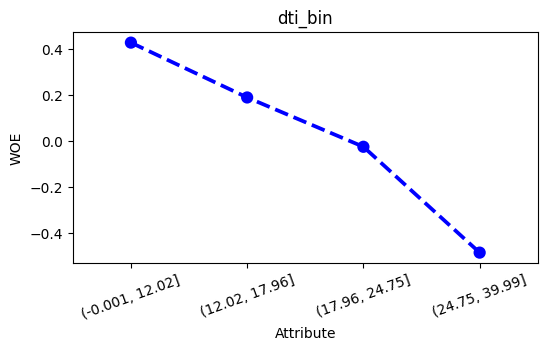

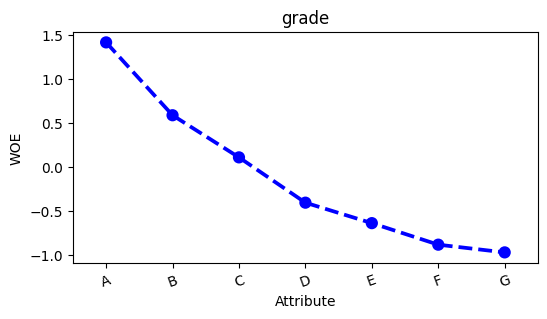

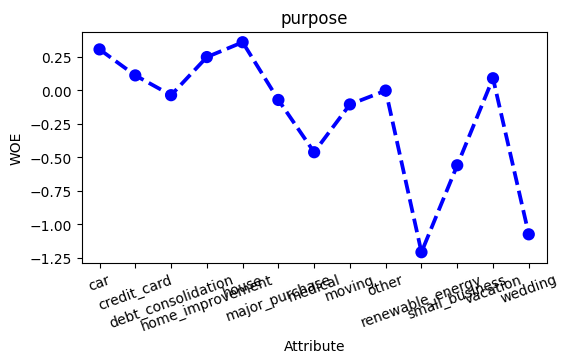

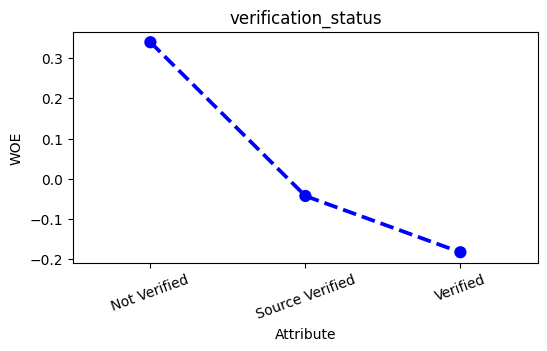

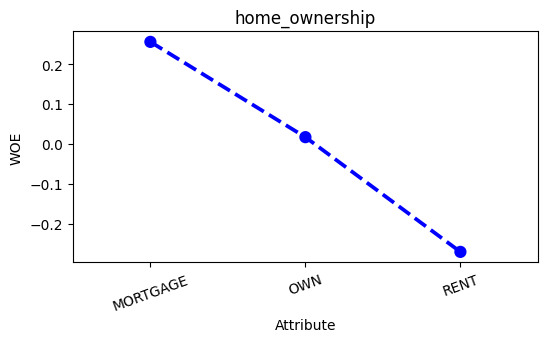

In [44]:
for char in char_list:

  crosstab = WOE_table[WOE_table['Characteristic'] == char]

  # Define the plot size and title
  plt.figure(figsize = (6,3))
  plt.title(char)

  # Plot the WOE
  sns.pointplot(x = crosstab['Attribute'],
                y = 'WOE',
                data = crosstab,
                markers = 'o',
                linestyles = '--',
                color = 'blue')

  # Rotate the label of x-axis
  plt.xticks(rotation = 20)

## **3.4 Test of Independence**
---

- Assume that the WOE for each attribute in all characteristics supports the logical trend and operational/business sense.
- Then, we can check the strength of each characteristic as a predictor of credit performance by its Information Value (IV).m

In [45]:
# Display the IV Table
IV_table

,Characteristic,Information Value,Strength
0,loan_amnt_bin,0.022271,Weak
1,int_rate_bin,0.326393,Strong
2,annual_inc_bin,0.039423,Weak
3,emp_length_bin,0.027479,Weak
4,dti_bin,0.115011,Medium
5,grade,0.368470,Strong
6,purpose,0.016371,Unpredictive
7,verification_status,0.039140,Weak
8,home_ownership,0.060851,Weak


- **Null Hypothesis:** The characteristic and response variable is independent.
- **Alternative Hypothesis:** The characteristic and response variable is not independent.
- **Test Statistic:**
  - Pearson Chi-squared Statistic

  $$
  \chi ^{2}=\sum \frac{(n_{ij}-\mu _{ij})^{2}}{\mu _{ij}}
  $$
  where
  $$
  \mu _{ij}=\frac{(n_{i+})(n_{+j})}{n}
  $$

  - degrees of freedom = $(I-1) \times (J-1)$
- **Rejection Region:**

$$
\begin{align*}
\chi^{2} &> \chi^{2}_{\alpha} \\
&\text{or} \\
P_{\text{value}} &< \alpha
\end{align*}
$$


In [46]:
# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Create a function of independence test
def independence_test(data, characteristic_label, alpha=0.05):
    """
    Function to perform the independence test.

    Parameters
    ----------
    data : array like
      The name of dataset.

    characteristic_label : object
      The label of characteristic variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    Return
    ------
    res : dataframe
      The summary result of the independence test.

    """
    # Build the contingency table
    crosstab = pd.crosstab(data[characteristic_label],
                           data[response_variable],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        conclusion = 'Not Independent'
    else:
        conclusion = 'Independent'

    # Tabulate the results
    res = pd.DataFrame({'Characteristic': characteristic_label,
                        'Chi-stat': round(stat,2),
                        'P-value': pval,
                        'Conclusion': conclusion},
                       index = [0])

    return res

In [47]:
# Define initial table to summarize the test result
ind_table = pd.DataFrame({'Characteristic': [],
                        'Chi-stat': [],
                        'P-value': [],
                        'Conclusion': []})

# Perform independence test for all characteristics
for characteristic in char_list:

  # Perform the independence test
  test_result = independence_test(data = data_train_binned,
                                  characteristic_label = characteristic,
                                  alpha = 0.05)

  # # Append test result to the table
  ind_table = pd.concat((ind_table, test_result),
                        axis = 0,
                        ignore_index = True)

In [48]:
# Check the results
ind_table

,Characteristic,Chi-stat,P-value,Conclusion
0,loan_amnt_bin,87.79,6.539387e-19,Not Independent
1,int_rate_bin,1248.24,2.506314e-270,Not Independent
2,annual_inc_bin,164.73,1.745541e-35,Not Independent
3,emp_length_bin,114.68,1.081444e-24,Not Independent
4,dti_bin,481.03,6.172090e-104,Not Independent
5,grade,1355.50,1.047131e-289,Not Independent
6,purpose,69.67,3.689378e-10,Not Independent
7,verification_status,152.96,6.087628e-34,Not Independent
8,home_ownership,249.89,5.467555e-55,Not Independent


All characteristics are not independent of the response variable (probability of default)

# **4. Design Scorecards**
---

- To design the scorecards, we will use a logistic regression model.
- We will perform the logistic regression not against the original input, but rather against the WOE of each grouping created in the previous step.

Therefore, we will transform the training set into the WOE value of each attribute.

## **4.1 Pre-processing Training Set**
---

First, create a function to generate a dictionary for mapping WOE values.

In [49]:
# Function to generate the WOE mapping dictionary
def get_woe_map_dict(WOE_table):

    # Initialize the dictionary
    WOE_map_dict = {}
    WOE_map_dict['Missing'] = {}

    unique_char = set(WOE_table['Characteristic'])
    for char in unique_char:
        # Get the Attribute & WOE info for each characteristics
        current_data = (WOE_table
                            [WOE_table['Characteristic']==char]     # Filter based on characteristic
                            [['Attribute', 'WOE']])                 # Then select the attribute & WOE

        # Get the mapping
        WOE_map_dict[char] = {}
        for idx in current_data.index:
            attribute = current_data.loc[idx, 'Attribute']
            woe = current_data.loc[idx, 'WOE']

            if attribute == 'Missing':
                WOE_map_dict['Missing'][char] = woe
            else:
                WOE_map_dict[char][attribute] = woe
                WOE_map_dict['Missing'][char] = np.nan

    # Validate data
    print('Number of key : ', len(WOE_map_dict.keys()))

    return WOE_map_dict


In [50]:
# Generate the WOE map dictionary
WOE_map_dict = get_woe_map_dict(WOE_table = WOE_table)
WOE_map_dict

Number of key :  10


{'Missing': {'dti_bin': nan,
  'int_rate_bin': nan,
  'verification_status': nan,
  'purpose': nan,
  'emp_length_bin': -0.39716643786213784,
  'home_ownership': nan,
  'grade': nan,
  'annual_inc_bin': nan,
  'loan_amnt_bin': nan},
 'dti_bin': {Interval(-0.001, 12.02, closed='right'): 0.42821598046918774,
  Interval(12.02, 17.96, closed='right'): 0.18971213452394886,
  Interval(17.96, 24.75, closed='right'): -0.024767214015408753,
  Interval(24.75, 39.99, closed='right'): -0.4851126973024375},
 'int_rate_bin': {Interval(5.319, 10.99, closed='right'): 0.9264254003227319,
  Interval(10.99, 13.66, closed='right'): 0.2513325104825956,
  Interval(13.66, 17.14, closed='right'): -0.2096253556271032,
  Interval(17.14, 28.99, closed='right'): -0.6673484479137359},
 'verification_status': {'Not Verified': 0.339515681489247,
  'Source Verified': -0.04275512353356569,
  'Verified': -0.18270131402339967},
 'purpose': {'car': 0.30597165055599257,
  'credit_card': 0.11185921004911481,
  'debt_consol

Next, we can transform the raw values in `X_train` into its WOE values.

In [51]:
# Function to replace the raw data in the train set with WOE values
def transform_woe(raw_data, WOE_dict, num_cols):

    woe_data = raw_data.copy()

    # Map the raw data
    for col in woe_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        woe_data[col] = woe_data[col].map(WOE_map_dict[map_col])

    # Map the raw data if there is a missing value or out of range value
    for col in woe_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        woe_data[col] = woe_data[col].fillna(value=WOE_map_dict['Missing'][map_col])

    return woe_data

In [52]:
# Transform the X_train
woe_train = transform_woe(raw_data = X_train,
                          WOE_dict = WOE_map_dict,
                          num_cols = num_columns)

woe_train

,loan_amnt,int_rate,grade,annual_inc,emp_length,purpose,verification_status,home_ownership,dti
id,,,,,,,,,
40634215,-0.044378,-0.667348,-0.636278,0.098009,0.164911,0.111859,-0.182701,-0.270079,-0.485113
40017494,-0.097108,0.251333,0.109605,0.098009,0.164911,-0.035750,-0.042755,0.255490,0.189712
39750768,-0.097108,-0.209625,-0.404171,0.098009,-0.065441,-0.035750,0.339516,-0.270079,-0.485113
46566810,-0.097108,0.926425,1.413524,0.098009,0.164911,-0.035750,0.339516,0.017016,0.189712
46834123,-0.116205,-0.209625,-0.404171,0.243588,0.164911,-0.035750,-0.042755,0.255490,-0.024767
...,...,...,...,...,...,...,...,...,...
51035774,-0.116205,0.251333,0.587327,0.243588,-0.146668,-0.035750,-0.042755,0.255490,0.189712
40930976,0.249249,0.251333,0.109605,-0.296823,-0.146668,-0.035750,-0.042755,-0.270079,-0.024767
40277505,-0.044378,-0.667348,-0.636278,-0.296823,-0.146668,-0.035750,-0.042755,-0.270079,-0.485113


## **4.2 Pre-processing Testing Set**
---

We have to pre-process the test data according to the pre-processing pipeline in train data.

Therefore, we transform the raw `X_test` into the WOE values from the train set.

In [53]:
# Transform the X_test
woe_test = transform_woe(raw_data = X_test,
                         WOE_dict = WOE_map_dict,
                         num_cols = num_columns)

woe_test

,loan_amnt,int_rate,grade,annual_inc,emp_length,purpose,verification_status,home_ownership,dti
id,,,,,,,,,
60317282,-0.097108,0.251333,0.109605,0.243588,-0.146668,-0.035750,0.339516,-0.270079,0.428216
39622059,-0.116205,0.926425,0.587327,0.098009,-0.065441,-0.035750,-0.042755,0.255490,0.189712
48021014,-0.097108,0.251333,0.109605,0.243588,0.164911,-0.071289,-0.042755,0.255490,-0.024767
51008496,-0.116205,-0.667348,-0.880538,0.098009,0.164911,-0.035750,-0.182701,0.017016,-0.485113
61534360,-0.116205,0.926425,0.587327,0.243588,0.164911,-0.035750,-0.042755,0.255490,-0.024767
...,...,...,...,...,...,...,...,...,...
48765853,-0.044378,0.926425,0.587327,-0.296823,-0.065441,0.111859,-0.042755,0.255490,-0.485113
54079549,0.249249,0.926425,0.587327,0.098009,0.164911,-0.035750,0.339516,0.255490,0.189712
38595384,-0.097108,-0.667348,-0.636278,0.098009,0.164911,-0.035750,-0.182701,0.255490,-0.485113


## **4.3 Logistic Regression Modeling**
---

In [54]:
# Rename the raw X_train for the future
raw_train = X_train
raw_train

,loan_amnt,int_rate,grade,annual_inc,emp_length,purpose,verification_status,home_ownership,dti
id,,,,,,,,,
40634215,11875,18.84,E,73000.0,10.0,credit_card,Verified,RENT,31.35
40017494,20000,12.99,C,75000.0,10.0,debt_consolidation,Source Verified,MORTGAGE,16.66
39750768,14400,17.14,D,70900.0,5.0,debt_consolidation,Not Verified,RENT,37.86
46566810,15000,6.92,A,84633.0,7.0,debt_consolidation,Not Verified,OWN,17.01
46834123,35000,16.55,D,248000.0,10.0,debt_consolidation,Source Verified,MORTGAGE,18.39
...,...,...,...,...,...,...,...,...,...
51035774,24000,11.53,B,120000.0,2.0,debt_consolidation,Source Verified,MORTGAGE,13.58
40930976,5200,12.69,C,42000.0,0.5,debt_consolidation,Source Verified,RENT,23.89
40277505,12000,21.99,E,26000.0,1.0,debt_consolidation,Source Verified,RENT,30.47


In [55]:
# Define X_train
X_train = woe_train.to_numpy()
X_train

array([[-0.04437814, -0.66734845, -0.63627796, ..., -0.18270131,
        -0.27007864, -0.4851127 ],
       [-0.09710796,  0.25133251,  0.10960494, ..., -0.04275512,
         0.25549013,  0.18971213],
       [-0.09710796, -0.20962536, -0.40417098, ...,  0.33951568,
        -0.27007864, -0.4851127 ],
       ...,
       [-0.04437814, -0.66734845, -0.63627796, ..., -0.04275512,
        -0.27007864, -0.4851127 ],
       [-0.11620494, -0.20962536, -0.40417098, ..., -0.18270131,
         0.25549013,  0.42821598],
       [-0.04437814,  0.25133251,  0.10960494, ...,  0.33951568,
         0.25549013,  0.18971213]])

We are ready for modeling.

But we need to find the best possible model using all available options.

- We will use the **Forward Selection** procedure since we have relatively many predictors.
- We use **Recall** or Sensitivity score to choose the best model, in which the model with the highest score is the best model.
  - The bad rate in our sample is relatively high, about 22%.
  - Thus we want to reduce the bad rate, which means
  - We want to maximize the rejection of bads (True Positive) or maximizes the True Positive Rate (TPR)/Recall/Sensitivity.

- To find the valid Recall score from each possible model, we use **10-Fold Cross-Validation** to calculate the Recall score.



#### **Perform Forward Selection**
---
Begin with null model (no predictors), then adds predictor that gives the greatest additional improvement to the model, one-at-a-time.

Define function `forward()` to fit a model on the train set and calculate its Recall score from the test set.

In [56]:
# Import library
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [57]:
def forward(X, y, predictors, scoring='roc_auc', cv=5):
    """
    Function to perform forward selection procedure.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
      All predictors set.

    y : {array-like} of shape (n_sample, )
      The dependent or response variable.

    predictors : {array-like} of shape (n_sample, )
      Index of predictors

    scoring : a single {str}, default='roc_auc'
      The scoring parameter based on scikit-learn cross_validate documentation.

    cv : int, default=5
      Number of folds for k-Fold CV.

    Returns
    -------
    models : {array-like} of shape (n_combinations, k)
      Summary of predictors and its AIC score for each possible combination.

    best_model : {array-like} of shape (2, )
      Best model of models with the smallest AIC score.
    """

    # Initialize list of results
    results = []

    # Define sample size and  number of all predictors
    n_samples, n_predictors = X.shape

    # Define list of all predictors
    col_list = np.arange(n_predictors)

    # Define remaining predictors for each k
    remaining_predictors = [p for p in col_list if p not in predictors]

    # Initialize list of predictors and its CV Score
    pred_list = []
    score_list = []

    # Cross validate each possible combination of remaining predictors
    for p in remaining_predictors:
        combi = predictors + [p]

        # Extract predictors combination
        X_ = X[:, combi]
        y_ = y

        # Define the estimator
        model = LogisticRegression(penalty = None,
                                   class_weight = 'balanced')

        # Cross validate the recall scores of the model
        cv_results = cross_validate(estimator = model,
                                    X = X_,
                                    y = y_,
                                    scoring = scoring,
                                    cv = cv)

        # Calculate the average CV/recall score
        score_ = np.mean(cv_results['test_score'])

        # Append predictors combination and its CV Score to the list
        pred_list.append(list(combi))
        score_list.append(score_)

    # Tabulate the results
    models = pd.DataFrame({"Predictors": pred_list,
                           "Recall": score_list})

    # Choose the best model
    best_model = models.loc[models['Recall'].argmax()]

    return models, best_model

First, check the function and fit the null model.

In [58]:
# Define predictor for the null model
predictor = []

# The predictor in the null model is zero values for all predictors
X_null = np.zeros((X_train.shape[0], 1))

# Define the estimator
model = LogisticRegression(penalty = None,
                           class_weight = 'balanced')

# Cross validate
cv_results = cross_validate(estimator = model,
                            X = X_null,
                            y = y_train,
                            cv = 10,
                            scoring = 'recall')

# Calculate the average CV/recall score
score_ = np.mean(cv_results['test_score'])

# Create table for the best model of each k predictors
# Append the results of null model
forward_models = pd.DataFrame({"Predictors": [predictor],
                               "Recall": [score_]})

In [59]:
# Display the table
forward_models

,Predictors,Recall
0,[],0.0


Next, perform the forward selection procedure for k=1,...,11 predictors.

In [60]:
# Define list of predictors
predictors = []
n_predictors = X_train.shape[1]

# Perform forward selection procedure for k=1,...,11 predictors
for k in range(n_predictors):
    _, best_model = forward(X = X_train,
                            y = y_train,
                            predictors = predictors,
                            scoring = 'recall',
                            cv = 10)

    # Tabulate the best model of each k predictors
    forward_models.loc[k+1] = best_model
    predictors = best_model['Predictors']

In [61]:
# Display the results
forward_models

,Predictors,Recall
0,[],0.000000
1,[6],0.802575
2,"[6, 5]",0.686679
3,"[6, 5, 1]",0.674493
4,"[6, 5, 1, 3]",0.686137
5,"[6, 5, 1, 3, 8]",0.671042
6,"[6, 5, 1, 3, 8, 4]",0.662488
7,"[6, 5, 1, 3, 8, 4, 2]",0.667764
8,"[6, 5, 1, 3, 8, 4, 2, 0]",0.667767
9,"[6, 5, 1, 3, 8, 4, 2, 0, 7]",0.662665


Next, find the best model with the highest Recall score.

In [62]:
# Find the best Recall score
best_idx = forward_models['Recall'].argmax()
best_recall = forward_models['Recall'].loc[best_idx]
best_predictors = forward_models['Predictors'].loc[best_idx]

# Print the summary
print('Best index            :', best_idx)
print('Best Recall           :', best_recall)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(raw_train.columns[best_predictors].tolist())

Best index            : 1
Best Recall           : 0.8025752608047689
Best predictors (idx) : [6]
Best predictors       :
['verification_status']


not makes sense if we use only 1 predictors

In [63]:
more_predictors = forward_models.loc[6:8]
more_predictors

,Predictors,Recall
6,"[6, 5, 1, 3, 8, 4]",0.662488
7,"[6, 5, 1, 3, 8, 4, 2]",0.667764
8,"[6, 5, 1, 3, 8, 4, 2, 0]",0.667767


In [64]:
# Find the best Recall score
best_idx = more_predictors['Recall'].idxmax()
best_recall = more_predictors['Recall'].loc[best_idx]
best_predictors = more_predictors['Predictors'].loc[best_idx]

# Print the summary
print('Best index            :', best_idx)
print('Best Recall           :', best_recall)
print('Best predictors (idx) :', best_predictors)
print('Best predictors       :')
print(raw_train.columns[best_predictors].tolist())

Best index            : 8
Best Recall           : 0.6677668488160291
Best predictors (idx) : [6, 5, 1, 3, 8, 4, 2, 0]
Best predictors       :
['verification_status', 'purpose', 'int_rate', 'annual_inc', 'dti', 'emp_length', 'grade', 'loan_amnt']


**Refit** the best model on whole `X_train` data.

In [65]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

Extract the best model' parameter estimates.

In [66]:
best_model_intercept = pd.DataFrame({'Estimate': best_model.intercept_},
                                    index = ["Intercept"])
best_model_intercept

,Estimate
Intercept,-0.000724


In [67]:
best_model_params = raw_train.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Estimate':  np.reshape(best_model.coef_, best_idx)},
                                index = best_model_params)

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0)

best_model_summary

,Estimate
Intercept,-0.000724
verification_status,-0.138591
purpose,-0.482622
int_rate,-0.190669
annual_inc,-0.554835
dti,-0.686868
emp_length,-0.995861
grade,-0.705019
loan_amnt,-0.784263


## **4.4 Model Evaluation**
---

#### **Predict on Train Data**
---

In [68]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([1, 0, 1, ..., 1, 0, 0])

In [69]:
# Import metrics package
from sklearn.metrics import recall_score

In [70]:
# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.6692139737991266

Recall score from the train set is 0.669

Want to check the distribution of the predicted probabilities?

In [71]:
# Predict the probability estimates
y_train_pred_proba = best_model.predict_proba(X_train_best)[:,[1]]
y_train_pred_proba

array([[0.66726615],
       [0.40721357],
       [0.67140581],
       ...,
       [0.78194659],
       [0.46201879],
       [0.47264897]])

<AxesSubplot: ylabel='Count'>

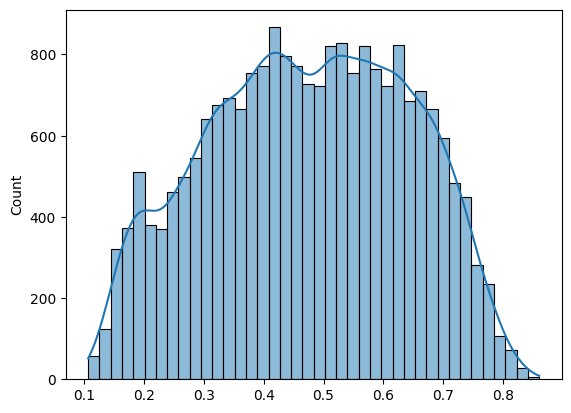

In [72]:
# Distribution plot of predicted probability
sns.histplot(x = np.reshape(y_train_pred_proba,
                            y_train.shape[0]),
             kde = True)

#### **Predict on Test Data**
---

In [73]:
# Rename the raw X_test for the future
raw_test = X_test

In [74]:
# Define X_test
X_test = woe_test.to_numpy()
X_test

array([[-0.09710796,  0.25133251,  0.10960494, ...,  0.33951568,
        -0.27007864,  0.42821598],
       [-0.11620494,  0.9264254 ,  0.58732742, ..., -0.04275512,
         0.25549013,  0.18971213],
       [-0.09710796,  0.25133251,  0.10960494, ..., -0.04275512,
         0.25549013, -0.02476721],
       ...,
       [-0.09710796, -0.66734845, -0.63627796, ..., -0.18270131,
         0.25549013, -0.4851127 ],
       [-0.11620494, -0.66734845, -0.63627796, ..., -0.18270131,
         0.25549013,  0.18971213],
       [ 0.24924945,  0.9264254 ,  0.58732742, ..., -0.18270131,
         0.25549013,  0.42821598]])

In [75]:
# Check y_test
y_test = y_test.to_numpy()
y_test

array([0, 0, 0, ..., 1, 0, 0])

In [76]:
from sklearn.impute import SimpleImputer
X_test_best = X_test[:, best_predictors]
# Instantiate an imputer
imputer = SimpleImputer(strategy='mean')  # You can choose another strategy based on your data

# Fit and transform the data
X_test_imputed = imputer.fit_transform(X_test_best)

# Predict using the imputed test data
y_test_pred = best_model.predict(X_test_imputed)
y_test_pred

array([0, 0, 0, ..., 1, 1, 0])

In [77]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.6666666666666666

Recall score from the test set is 0.66.

Check the distribution of the predicted probabilities.

In [78]:
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')  # You can use different strategies here

# Fit and transform X_test_best
X_test_imputed = imputer.fit_transform(X_test_best)

# Predict the probability estimates
y_test_pred_proba = best_model.predict_proba(X_test_imputed)[:, [1]]


<AxesSubplot: ylabel='Count'>

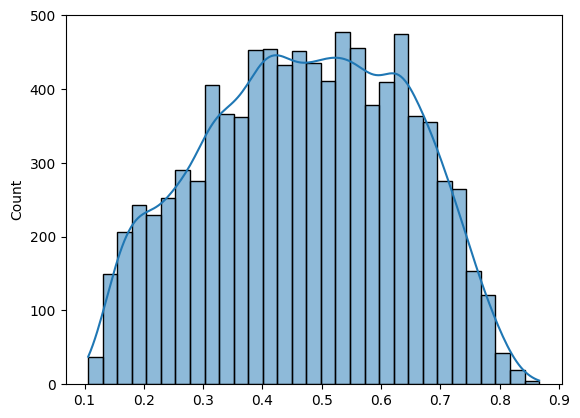

In [79]:
# Distribution plot of predicted probability
sns.histplot(x = np.reshape(y_test_pred_proba,
                            y_test.shape[0]),
             kde = True)

## **4.5 Model Adjustment**
---

Scorecards with too few characteristics are generally unable to withstand the test of time:
  - They are susceptible to minor changes in the applicant profile.
  - A good adjudicator will never look at just two characteristics from an application form to make a decision.

We will include all characteristics in the final model.
  - From the independence test, all characteristics are not independent of the response variable (probability of default).
  - Generally, a final scorecards consist of between 8 and 15 characteristics


In [80]:
best_predictors = forward_models['Predictors'].loc[len(predictors)]

In [81]:
# Define X with best predictors
X_train_best = X_train[:, best_predictors]

# Fit best model
best_model = LogisticRegression(penalty = None,
                                class_weight = 'balanced')
best_model.fit(X_train_best, y_train)

LogisticRegression(class_weight='balanced', penalty=None)

Extract the best model' parameter estimates.

In [82]:
best_model_intercept = pd.DataFrame({'Characteristic': 'Intercept',
                                     'Estimate': best_model.intercept_})
best_model_intercept

,Characteristic,Estimate
0,Intercept,-0.001178


In [83]:
best_model_params = raw_train.columns[best_predictors].tolist()
best_model_coefs = pd.DataFrame({'Characteristic':  best_model_params,
                                 'Estimate':        np.reshape(best_model.coef_,
                                                               len(best_predictors))})

best_model_summary = pd.concat((best_model_intercept, best_model_coefs),
                               axis = 0,
                               ignore_index = True)

best_model_summary

,Characteristic,Estimate
0,Intercept,-0.001178
1,verification_status,-0.097196
2,purpose,-0.376621
3,int_rate,-0.191656
4,annual_inc,-0.374202
5,dti,-0.708000
6,emp_length,-0.889052
7,grade,-0.696761
8,loan_amnt,-0.877968
9,home_ownership,-0.813763


#### **Predict on Train Data**
---

In [84]:
# Predict class labels for sample in X_train.
y_train_pred = best_model.predict(X_train_best)
y_train_pred

array([1, 0, 1, ..., 1, 0, 0])

In [85]:
# Calculate the recall score on the train set
recall_train = recall_score(y_true = y_train,
                            y_pred = y_train_pred)

recall_train

0.6630276564774381

In [86]:
# Using method sklearn.metrics.roc_curve
from sklearn import metrics

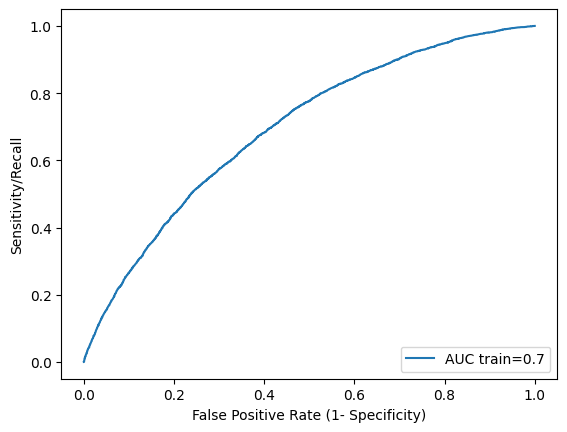

In [87]:
# Predict probability of default on X_train
y_train_pred_proba = best_model.predict_proba(X_train_best)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr, tpr, threshold = metrics.roc_curve(y_true = y_train,
                                        y_score = y_train_pred_proba[:,1])

# Calculate AUC score using method sklearn.metrics.roc_auc_score
auc_train = metrics.roc_auc_score(y_true = y_train,
                                  y_score = y_train_pred_proba[:,1])
auc_train = round(auc_train, 2)

# Plot ROC and its AUC
plt.plot(fpr,
         tpr,
         label = "AUC train="+str(auc_train))

plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc = 4)
plt.show()

<AxesSubplot: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

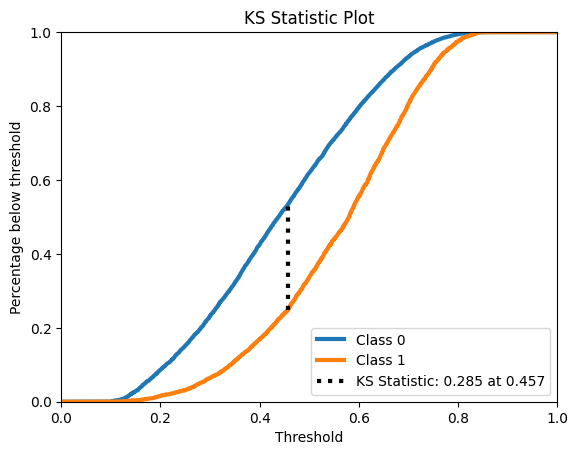

In [88]:
# Plot KS Statistic
import scikitplot as skplt
skplt.metrics.plot_ks_statistic(y_train,
                                y_train_pred_proba)

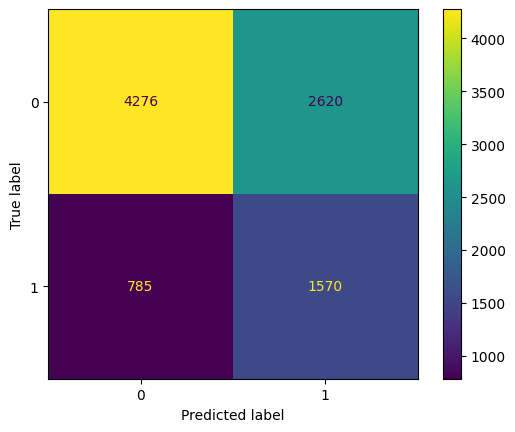

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

#### **Predict on Test Data**
---

In [90]:
from sklearn.impute import SimpleImputer
X_test_best = X_test[:, best_predictors]
# Instantiate an imputer
imputer = SimpleImputer(strategy='mean')  # You can choose another strategy based on your data

# Fit and transform the data
X_test_imputed = imputer.fit_transform(X_test_best)

# Predict using the imputed test data
y_test_pred = best_model.predict(X_test_imputed)
y_test_pred

array([0, 0, 0, ..., 1, 1, 0])

In [91]:
# Calculate the recall score on the test set
recall_test = recall_score(y_true = y_test,
                           y_pred = y_test_pred)

recall_test

0.6653927813163482

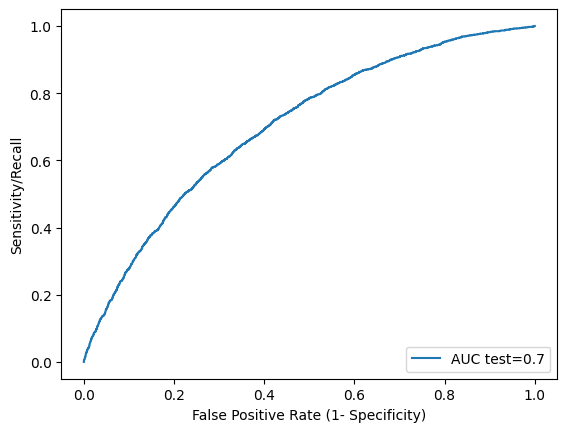

In [92]:
from sklearn.impute import SimpleImputer

# Initialize an imputer and fit it on your X_test_best data
imputer = SimpleImputer(strategy='mean')  # You can choose 'mean', 'median', 'most_frequent', etc.
X_test_best_imputed = imputer.fit_transform(X_test_best)

# Predict probability of default on the imputed X_test_best data
y_test_pred_proba = best_model.predict_proba(X_test_best_imputed)

# Calculate sensitivity (TPR) and 1-specificity (FPR) from each possible threshold
fpr_, tpr_, threshold_ = metrics.roc_curve(y_true=y_test, y_score=y_test_pred_proba[:, 1])

# Calculate AUC score using sklearn.metrics.roc_auc_score
auc_test = metrics.roc_auc_score(y_true=y_test, y_score=y_test_pred_proba[:, 1])
auc_test = round(auc_test, 2)

# Plot ROC and its AUC
plt.plot(fpr_, tpr_, label="AUC test=" + str(auc_test))
plt.ylabel("Sensitivity/Recall")
plt.xlabel("False Positive Rate (1- Specificity)")
plt.legend(loc=4)
plt.show()


<AxesSubplot: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

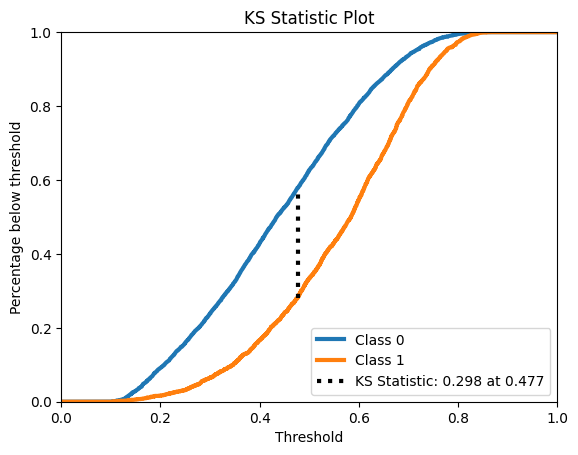

In [93]:
# Plot KS Statistic
skplt.metrics.plot_ks_statistic(y_test,
                                y_test_pred_proba)

- The sensitivity/recall score from the adjusted model is 0.66 on the train set and 0.66 on the test set.
- The AUC from the adjusted model is not quite good; 0.66 on the train set and 0.66 on the test set.

The sensitivity/recall score difference between the adjusted model and the best model from the forward selection is trivial.

# **5. Scaling**
---

## **5.1 Create Scorecards**
---

Assign score to each attribute by specifying:
- Odds of good of 30:1 at 300 points score, and
- 20 PDO (points to double the odds of good).

Thus, we can calculate the offset and factor:
- $\text{Factor}=\text{PDO}/ \ln(2)$
- $\text{Offset} = \text{Score} − {\text{Factor} ∗ \ln (\text{Odds of good})}$

In [94]:
# Define Factor and Offset
factor = 20/np.log(2)
offset = 300-(factor*np.log(30))

print(f"Offset = {offset:.2f}")
print(f"Factor = {factor:.2f}")

Offset = 201.86
Factor = 28.85


Therefore, the score point for each attribute $j$ in each characteristic $i$:
$$
\frac{\text{Offset}}{n} - \text{Factor} \times \left (\frac{\beta_0}{n}  + \beta_i \times \text{WOE}_j \right )
$$


In [95]:
# Define n = number of characteristics
n = len(best_predictors)

# Define b0
b0 = best_model.intercept_[0]

print(f"n = {n}")
print(f"b0 = {b0:.4f}")

n = 9
b0 = -0.0012


Next, assign the score point to each attribute.

In [96]:
# Adjust characteristic name in best_model_summary_table
for col in best_model_summary['Characteristic']:
  if col in num_columns:
    bin_col = col + '_bin'
  else:
    bin_col = col
  best_model_summary.replace(col, bin_col, inplace = True)


# Merge tables to get beta_i for each characteristic
scorecards = pd.merge(left = WOE_table,
                      right = best_model_summary,
                      how = 'left',
                      on = ['Characteristic'])

scorecards.head()

,Characteristic,Attribute,WOE,Estimate
0,loan_amnt_bin,"(999.999, 8000.0]",0.249249,-0.877968
1,loan_amnt_bin,"(8000.0, 12600.0]",-0.044378,-0.877968
2,loan_amnt_bin,"(12600.0, 20000.0]",-0.097108,-0.877968
3,loan_amnt_bin,"(20000.0, 35000.0]",-0.116205,-0.877968
4,int_rate_bin,"(5.319, 10.99]",0.926425,-0.191656


In [97]:
# Define beta and WOE
beta = scorecards['Estimate']
WOE = scorecards['WOE']

# Calculate the score point for each attribute
scorecards['Points'] = (offset/n) - factor*((b0/n) + (beta*WOE))
scorecards['Points'] = scorecards['Points'].astype('int')

scorecards

,Characteristic,Attribute,WOE,Estimate,Points
0,loan_amnt_bin,"(999.999, 8000.0]",0.249249,-0.877968,28
1,loan_amnt_bin,"(8000.0, 12600.0]",-0.044378,-0.877968,21
2,loan_amnt_bin,"(12600.0, 20000.0]",-0.097108,-0.877968,19
3,loan_amnt_bin,"(20000.0, 35000.0]",-0.116205,-0.877968,19
4,int_rate_bin,"(5.319, 10.99]",0.926425,-0.191656,27
5,int_rate_bin,"(10.99, 13.66]",0.251333,-0.191656,23
6,int_rate_bin,"(13.66, 17.14]",-0.209625,-0.191656,21
7,int_rate_bin,"(17.14, 28.99]",-0.667348,-0.191656,18
8,annual_inc_bin,"(6634.999, 45000.0]",-0.296823,-0.374202,19
9,annual_inc_bin,"(45000.0, 65000.0]",0.007843,-0.374202,22


In [98]:
# Calculate the min and max points for each characteristic
grouped_char = scorecards.groupby('Characteristic')
grouped_points = grouped_char['Points'].agg(['min', 'max'])
grouped_points

,min,max
Characteristic,,
annual_inc_bin,19,25
dti_bin,12,31
emp_length_bin,12,26
grade,2,50
home_ownership,16,28
int_rate_bin,18,27
loan_amnt_bin,19,28
purpose,9,26
verification_status,21,23


In [99]:
# Calculate the min and max score from the scorecards
total_points = grouped_points.sum()
min_score = total_points['min']
max_score = total_points['max']

print(f"The lowest credit score = {min_score}")
print(f"The highest credit score = {max_score}")

The lowest credit score = 128
The highest credit score = 264


## **5.2 Predict Credit Score**
---

To predict a credit score from an input, we need to:
- Transform the raw input value into the score point
- Calculate the total score points

Therefore, we will:
- Generate the points map dictionary for each attribute
- Transform the raw input value into the score point according to its attribute

In [100]:
# Function to generate the points map dictionary
def get_points_map_dict(scorecards):

    # Initialize the dictionary
    points_map_dict = {}
    points_map_dict['Missing'] = {}
    unique_char = set(scorecards['Characteristic'])
    for char in unique_char:
        # Get the Attribute & WOE info for each characteristics
        current_data = (scorecards
                            [scorecards['Characteristic']==char]     # Filter based on characteristic
                            [['Attribute', 'Points']])               # Then select the attribute & WOE

        # Get the mapping
        points_map_dict[char] = {}
        for idx in current_data.index:
            attribute = current_data.loc[idx, 'Attribute']
            points = current_data.loc[idx, 'Points']

            if attribute == 'Missing':
                points_map_dict['Missing'][char] = points
            else:
                points_map_dict[char][attribute] = points
                points_map_dict['Missing'][char] = np.nan

    return points_map_dict


In [101]:
# Generate the points map dict
points_map_dict = get_points_map_dict(scorecards = scorecards)
points_map_dict

{'Missing': {'dti_bin': nan,
  'int_rate_bin': nan,
  'verification_status': nan,
  'purpose': nan,
  'emp_length_bin': 12,
  'home_ownership': nan,
  'grade': nan,
  'annual_inc_bin': nan,
  'loan_amnt_bin': nan},
 'dti_bin': {Interval(-0.001, 12.02, closed='right'): 31,
  Interval(12.02, 17.96, closed='right'): 26,
  Interval(17.96, 24.75, closed='right'): 21,
  Interval(24.75, 39.99, closed='right'): 12},
 'int_rate_bin': {Interval(5.319, 10.99, closed='right'): 27,
  Interval(10.99, 13.66, closed='right'): 23,
  Interval(13.66, 17.14, closed='right'): 21,
  Interval(17.14, 28.99, closed='right'): 18},
 'verification_status': {'Not Verified': 23,
  'Source Verified': 22,
  'Verified': 21},
 'purpose': {'car': 25,
  'credit_card': 23,
  'debt_consolidation': 22,
  'home_improvement': 25,
  'house': 26,
  'major_purchase': 21,
  'medical': 17,
  'moving': 21,
  'other': 22,
  'renewable_energy': 9,
  'small_business': 16,
  'vacation': 23,
  'wedding': 10},
 'emp_length_bin': {Interva

Assume we have a raw input:

In [102]:
input = {
    'loan_amnt_bin':2000,
    'int_rate_bin':8,
    'grade':'B',
    'annual_inc_bin':9000,
    'emp_length_bin':8,
    'purpose':'home_improvement',
    'verification_status':'Verified',
    'home_ownership':'MORTGAGE'
}

In [103]:
#data['purpose'].unique()

In [104]:
def transform_points(raw_data, points_map_dict, num_cols):

    points_data = raw_data.copy()

    # Map the data
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].map(points_map_dict[map_col])

    # Map the data if there is a missing value or out of range value
    for col in points_data.columns:
        if col in num_cols:
            map_col = col + '_bin'
        else:
            map_col = col

        points_data[col] = points_data[col].fillna(value=points_map_dict['Missing'][map_col])

    return points_data

In [105]:
input_table = pd.DataFrame(input, index=[0])
input_points = transform_points(raw_data = input_table,
                                points_map_dict = points_map_dict,
                                num_cols = num_columns)

input_points

,loan_amnt_bin,int_rate_bin,grade,annual_inc_bin,emp_length_bin,purpose,verification_status,home_ownership
0,28,27,34,19,26,25,21,28


Now we can calculate the credit score.

In [106]:
# Function to predict the credit score
def predict_score(raw_data, cutoff_score):

    # Transform raw input values into score points
    points = transform_points(raw_data = raw_data,
                              points_map_dict = points_map_dict,
                              num_cols = num_columns)

    # Caculate the score as the total points
    score = int(points.sum(axis=1))

    print(f"Credit Score : ", score)

    if score > cutoff_score:
        print("Recommendation : APPROVE")
    else:
        print("Recommendation : REJECT")

    return score

In [107]:
input_score = predict_score(raw_data = input_table,
                            cutoff_score = 150)

Credit Score :  208
Recommendation : APPROVE


### **Predict Score on Train Set**
---

In [108]:
# Transform the raw values in X_train into points
train_points = transform_points(raw_data = raw_train,
                                points_map_dict = points_map_dict,
                                num_cols = num_columns)

train_points.head()

,loan_amnt,int_rate,grade,annual_inc,emp_length,purpose,verification_status,home_ownership,dti
id,,,,,,,,,
40634215,21,18,9,23,26.0,23,21,16,12
40017494,19,23,24,23,26.0,22,22,28,26
39750768,19,21,14,23,20.0,22,23,16,12
46566810,19,27,50,23,26.0,22,23,22,26
46834123,19,21,14,25,26.0,22,22,28,21


In [109]:
# Calculate the total score
train_points['Score'] = train_points.sum(axis=1).astype(int)

train_points[['loan_amnt', 'Score']].head()

,loan_amnt,Score
id,,
40634215,21,169
40017494,19,213
39750768,19,170
46566810,19,238
46834123,19,198


## **5.3 Setting Cutoff**
---

To set the cutoff score, we need information of:

- Expected approval rate from:
  - Most current applicant distribution — most recent month/quarter.

- Expected bad rate from:
  - Development sample, or
  - Most recent sample — use performance window for the scorecard.

Since we don't hace the most recent credit applications data, we will:
- Estimate the expected approval rate from the test set.
- Estimate the expected bad rate from the train set.


### **Estimate the Expected Approval Rate**
---

In [110]:
cutoff_list = []
approval_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  approve_counts = len(train_points[train_points['Score'] >= cutoff])
  n_sample = len(train_points)

  approval_rate = approve_counts/n_sample

  approval_rate_list.append(approval_rate)

approval_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                                    'Expected Approval Rate' : approval_rate_list})

approval_rate_table

,Cutoff,Expected Approval Rate
0,128,1.000000
1,129,1.000000
2,130,1.000000
3,131,1.000000
4,132,1.000000
...,...,...
131,259,0.002039
132,260,0.001390
133,261,0.000602
134,262,0.000278


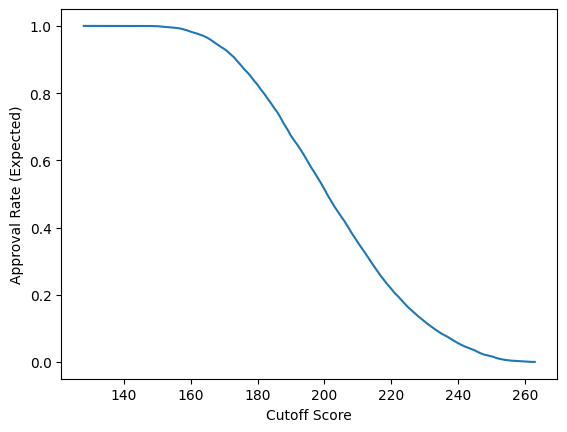

In [111]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

plt.xlabel('Cutoff Score')
plt.ylabel('Approval Rate (Expected)')
plt.show()

### **Estimate the Expected Bad Rate**
---

In [112]:
cutoff_list = []
bad_rate_list = []

for cutoff in range (int(min_score), int(max_score)):

  cutoff_list.append(cutoff)

  bad_counts = len(train_points[train_points['Score'] < cutoff])
  n_sample = len(train_points)

  bad_rate = bad_counts/n_sample

  bad_rate_list.append(bad_rate)

bad_rate_table = pd.DataFrame({'Cutoff' : cutoff_list,
                               'Expected Bad Rate' : bad_rate_list})

bad_rate_table

,Cutoff,Expected Bad Rate
0,128,0.000000
1,129,0.000000
2,130,0.000000
3,131,0.000000
4,132,0.000000
...,...,...
131,259,0.997961
132,260,0.998610
133,261,0.999398
134,262,0.999722


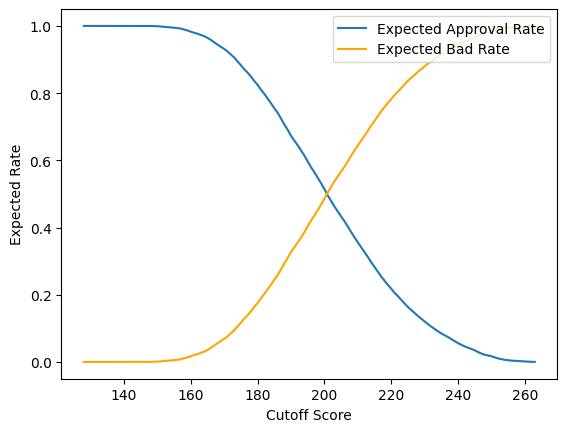

In [113]:
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

# Plot the expected bad rate
plt.plot(bad_rate_table['Cutoff'],
         bad_rate_table['Expected Bad Rate'],
         label = "Expected Bad Rate",
         color = 'orange')

plt.ylabel("Expected Rate")
plt.xlabel("Cutoff Score")
plt.legend(loc = 1)
plt.show()

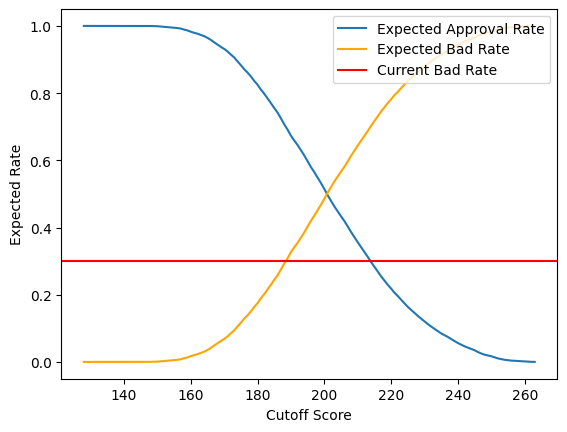

In [114]:
# Add line for visualization
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

# Plot the expected bad rate
plt.plot(bad_rate_table['Cutoff'],
         bad_rate_table['Expected Bad Rate'],
         label = "Expected Bad Rate",
         color = 'orange')

plt.axhline(y=0.3, color='r', linestyle='-', label = "Current Bad Rate")

plt.ylabel("Expected Rate")
plt.xlabel("Cutoff Score")
plt.legend(loc = 1)

plt.show()

Which cutoff will we choose?

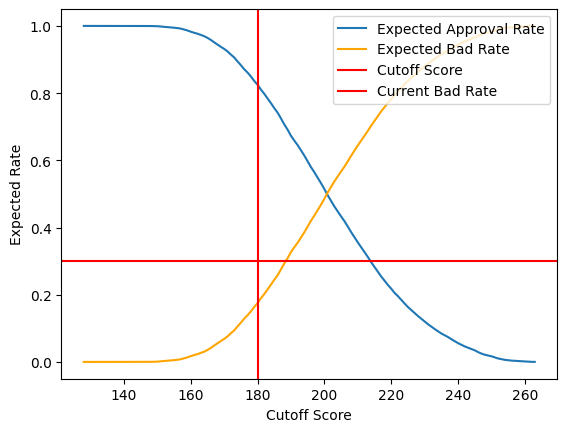

In [115]:
# Add line for visualization
# Plot the approval rate
plt.plot(approval_rate_table['Cutoff'],
         approval_rate_table['Expected Approval Rate'],
         label = "Expected Approval Rate")

# Plot the expected bad rate
plt.plot(bad_rate_table['Cutoff'],
         bad_rate_table['Expected Bad Rate'],
         label = "Expected Bad Rate",
         color = 'orange')

plt.axvline(x=180, color='r', linestyle='-', label = "Cutoff Score")
plt.axhline(y=0.3, color='r', linestyle='-', label = "Current Bad Rate")


plt.ylabel("Expected Rate")
plt.xlabel("Cutoff Score")
plt.legend(loc = 1)

plt.show()